In [1]:
import geemap
import ee
from osgeo import gdal, ogr, osr
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import os


In [2]:
m = geemap.Map()
m.add_basemap('HYBRID')

In [8]:
area_gpd = gpd.read_file('D:/ibge/municipios/2010/15MUE250GC_SIR.shp') # Municípios do Brasil - IBGE

print(*area_gpd['NM_MUNICIP'], sep="\n") # lista de municípios 

ABAETETUBA
ABEL FIGUEIREDO
ACARÁ
AFUÁ
ÁGUA AZUL DO NORTE
ALENQUER
ALMEIRIM
ALTAMIRA
ANAJÁS
ANANINDEUA
ANAPU
AUGUSTO CORRÊA
AURORA DO PARÁ
AVEIRO
BAGRE
BAIÃO
BANNACH
BARCARENA
BELÉM
BELTERRA
BENEVIDES
BOM JESUS DO TOCANTINS
BONITO
BRAGANÇA
BRASIL NOVO
BREJO GRANDE DO ARAGUAIA
BREU BRANCO
BREVES
BUJARU
CACHOEIRA DO PIRIÁ
CACHOEIRA DO ARARI
CAMETÁ
CANAÃ DOS CARAJÁS
CAPANEMA
CAPITÃO POÇO
CASTANHAL
CHAVES
COLARES
CONCEIÇÃO DO ARAGUAIA
CONCÓRDIA DO PARÁ
CUMARU DO NORTE
CURIONÓPOLIS
CURRALINHO
CURUÁ
CURUÇÁ
DOM ELISEU
ELDORADO DOS CARAJÁS
FARO
FLORESTA DO ARAGUAIA
GARRAFÃO DO NORTE
GOIANÉSIA DO PARÁ
GURUPÁ
IGARAPÉ-AÇU
IGARAPÉ-MIRI
INHANGAPI
IPIXUNA DO PARÁ
IRITUIA
ITAITUBA
ITUPIRANGA
JACAREACANGA
JACUNDÁ
JURUTI
LIMOEIRO DO AJURU
MÃE DO RIO
MAGALHÃES BARATA
MARABÁ
MARACANÃ
MARAPANIM
MARITUBA
MEDICILÂNDIA
MELGAÇO
MOCAJUBA
MOJU
MONTE ALEGRE
MUANÁ
NOVA ESPERANÇA DO PIRIÁ
NOVA IPIXUNA
NOVA TIMBOTEUA
NOVO PROGRESSO
NOVO REPARTIMENTO
ÓBIDOS
OEIRAS DO PARÁ
ORIXIMINÁ
OURÉM
OURILÂNDIA DO NORTE
PACAJÁ
PA

<AxesSubplot:>

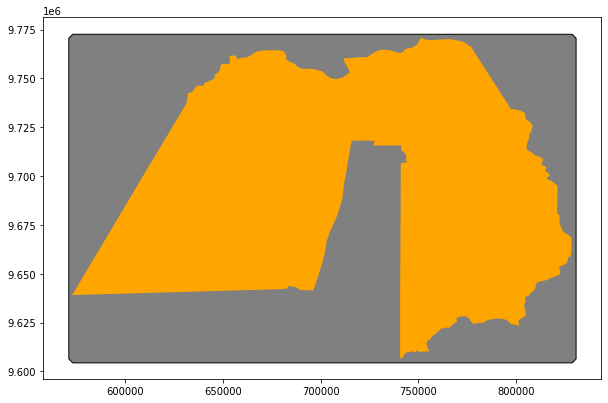

In [9]:
municipio = 'SANTARÉM' # Municípios do Brasil - IBGE
area_gpd = area_gpd[area_gpd['NM_MUNICIP']== municipio ]

# se estiver em Coordenadas Geográficas, entao usar o buffer em grau. Tabela: https://pt.wikipedia.org/wiki/Graus_decimais
# 0.01 =~ 1.1132 Km

# se possível utilizar em UTM, mude a projeção. Utilize algum arquivo de referencia. 
arquivo_utm = gpd.read_file('D:/INPE_DISCIPLINAS/Dissertacao/shapes/vias/vias_str_uniao.shp')

area_gpd = area_gpd.to_crs(arquivo_utm.crs)

buffer = 2000

bb = area_gpd.envelope.buffer(buffer, 1)

base = bb.plot(color='grey', edgecolor='black', figsize=(10, 20))
area_gpd.plot(ax=base, marker='o', color='orange', markersize=5, figsize=(15, 30))

In [5]:
# exportar o boundbox

bandaLuzNot = 'D:/INPE_DISCIPLINAS/Dissertacao/raster/'
nome = 'testeCOMPLETO.tif'

boundbox = str(bandaLuzNot+nome)

if os.path.exists(boundbox):
    os.remove(boundbox)

bb.to_file(boundbox, mode = 'w')

# Vizualisar a luz noturna a partir de boundbox e ver se é o dado desejado
t = geemap.shp_to_ee(boundbox)

d1 = '2020-01-01' # data de início da colecao de imagens 
d2 = '2020-12-31' # data de término da colecao de imagens

# Imagem de luz noturna com filtros de área e data
colecao = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMCFG").filterBounds(t).filterDate(d1, d2)

luz_not = colecao.mean().clip(t).select('avg_rad') # média da colecao

Map = geemap.Map()
Map.centerObject(t, 8)

Map.addLayer(t, {}, 'boundbox')
Map.addLayer(luz_not, {'min': 0, 'max': 0.5}, 'luz not')
Map

Map(center=[-2.813848232817539, -55.19493961021891], controls=(WidgetControl(options=['position', 'transparent…

In [5]:
#Exportar raster das luzes noturnas 

out_dir = os.path.join(os.path.expanduser('~'), bandaLuzNot)
filename = os.path.join(out_dir, nome)

if os.path.exists(bandaLuzNot+nome):
    os.remove(bandaLuzNot+nome)

geemap.ee_export_image(
    luz_not, filename=filename, region =  t.geometry(), scale=500, file_per_band=False
)

Generating URL ...
Please wait ...
Data downloaded to D:\INPE_DISCIPLINAS\Dissertacao\raster\testeCOMPLETO.tif


**Identificando o limiar de luz noturna**
vou tentar pegar o dado de luz noturna gerado pelo GEE e fazer os mesmos procedimentos

In [10]:
########### ABRIR ARQUIVO RASTER #######################

ds = gdal.Open(bandaLuzNot+nome)
gt = ds.GetGeoTransform()
proj = ds.GetProjection()

band = ds.GetRasterBand(1)
array = band.ReadAsArray()

In [11]:
print(ds.GetProjectionRef())
coords = ds.GetProjectionRef()

GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]


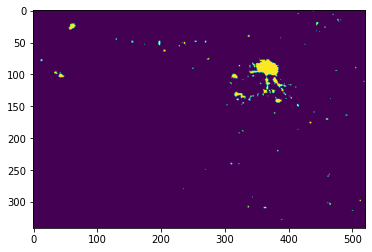

In [12]:
plt.imshow(array > 1)

In [37]:
# CAMETA E STR 2020
sc_urb = 'D:/ibge/setor_censi/2020/PA_Setores_2020.shp' # Setores Censitários 2020

area_urb_peri = gpd.read_file(sc_urb)

area_urb_peri.head()

#print(*sorted(set(area_urb_peri['NM_MUN'])), sep='\n'  )  # ver lista de municípios

,CD_SETOR,CD_SIT,NM_SIT,CD_UF,NM_UF,SIGLA_UF,CD_MUN,NM_MUN,CD_DIST,NM_DIST,CD_SUBDIST,NM_SUBDIST,caso,situacaoNu,perim_peri,pera_buen,area_peri,NM_MUNICIP,MUNICIPIO,geometry
0,150010705000002,1,Área Urbana de Alta Densidade de Edificações,15,Pará,PA,1500107,Abaetetuba,150010705,Abaetetuba,15001070500,None,NaN,NaN,None,None,NaN,None,None,"POLYGON ((-48.87808 -1.72317, -48.87915 -1.724..."
1,150010705000003,1,Área Urbana de Alta Densidade de Edificações,15,Pará,PA,1500107,Abaetetuba,150010705,Abaetetuba,15001070500,None,NaN,NaN,None,None,NaN,None,None,"POLYGON ((-48.88343 -1.72663, -48.88333 -1.726..."
2,150010705000004,1,Área Urbana de Alta Densidade de Edificações,15,Pará,PA,1500107,Abaetetuba,150010705,Abaetetuba,15001070500,None,NaN,NaN,None,None,NaN,None,None,"POLYGON ((-48.88702 -1.72808, -48.88432 -1.728..."
3,150010705000005,1,Área Urbana de Alta Densidade de Edificações,15,Pará,PA,1500107,Abaetetuba,150010705,Abaetetuba,15001070500,None,NaN,NaN,None,None,NaN,None,None,"POLYGON ((-48.88675 -1.72717, -48.88702 -1.728..."
4,150010705000006,1,Área Urbana de Alta Densidade de Edificações,15,Pará,PA,1500107,Abaetetuba,150010705,Abaetetuba,15001070500,None,NaN,NaN,None,None,NaN,None,None,"POLYGON ((-48.88640 -1.72506, -48.88482 -1.725..."


In [3]:
########## ABRIR ARQUIVO SHP DOS BUFFERS SELECIONADOS #######################################
# CAMETA E STR 2020
sc_urb = 'D:/ibge/setor_censi/2020/PA_Setores_2020.shp'

area_urb_peri = gpd.read_file(sc_urb)
area_urb_peri = area_urb_peri[area_urb_peri['NM_MUNICIP']=='SANTARÉM'] #  CAMETÁ
area_urb_peri = area_urb_peri[area_urb_peri['area_peri'].isin([1,2,5]) ] # setor 1 - urb alt adens.; 2 - urb baixo adensa; 5 - povoado

area_urb_peri[0:3]
area_urb_peri.plot(marker='o', color='red', markersize=5, edgecolor = 'black')


#area_urb.head()

NameError: name 'gpd' is not defined

In [48]:
area_urb_peri['ID'] = range(1, len(area_urb_peri['geometry']) + 1)
area_urb_peri['ID'][0:5]


<Geographic 2D CRS: EPSG:4674>
Name: SIRGAS 2000
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: Latin America - Central America and South America - onshore and offshore. Brazil - onshore and offshore.
- bounds: (-122.19, -59.87, -25.28, 32.72)
Datum: Sistema de Referencia Geocentrico para las AmericaS 2000
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

epsg:4674 
 alterando EPSG 

epsg alterado para -> epsg:4674


Text(0.5, 1.0, 'D:/ibge/setor_censi/2020/PA_Setores_2020.shp')

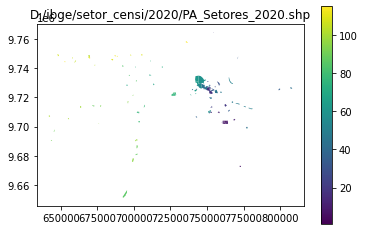

In [49]:
# ALTERAR EPSG para UTM novamente

print(area_urb_peri.crs, '\n alterando EPSG \n')
area_urb_peri = area_urb_peri.to_crs(arquivo_utm.crs)
print('epsg alterado para ->',area_urb_peri.crs)

area_urb_peri.plot(column= 'ID', legend = True)
plt.title(sc_urb)

In [12]:
########################### MODIFICAR PARA OS DESTINOS ESPECÍFICOS DESEJADOS #################################################
a = 'False'
limiar = 0.8   # limiar inicial a ser utilizado na imagem
per = 0 # porcentagem
limiarizado = 'D:/INPE_DISCIPLINAS/Dissertacao/testes/luzNot_CAMETA_2020_Limiar_within_COMPLETO.tif'  # local do arquivo limiarizado.tif     #
out_path = 'D:/INPE_DISCIPLINAS/Dissertacao/testes/luzNot_CAMETA_2020_Limiar_within_COMPLETO.shp' # LOCAL SHP LIMIARIZADO
bloco_notas = 'D:/INPE_DISCIPLINAS/Dissertacao/testes/luzNot_CAMETA_2020_Limiar_within_COMPLETO.txt'  # local armazenado os valores de limiares testados #

epsg = int(4326) # colocar somento o identificador do epsg
EPSG = coords # inserir após "EPSG:" o identificador do epsg

arquivos = [limiarizado, out_path, bloco_notas]
for i in arquivos:
    if os.path.exists(i):
        os.remove(i)
        print(f'removido: {i}')
    else:
        print(f'sem arquivos com nomes repetidos')

sem arquivos com nomes repetidos
sem arquivos com nomes repetidos
sem arquivos com nomes repetidos


In [13]:
while per < 0.6: # PORCENTAGEM DE SETORES QUE INTERSECTAM COM O LIMIAR.
                 # a partir de testes foi verificado resultados satisfatórios com: STR = 0.7; CMT = 0.6
    ####################### EXPORTANDO O RASTER LIMIARIZADO ######################
    '''
    NESSA PARTE USA O LIMIARIZADO E O LIMIAR
    '''
    print('teste limiar: ', limiar)
    classificacao = array > limiar

    if os.path.exists(limiarizado):
        os.remove(limiarizado) 
        
    driver = gdal.GetDriverByName('GTiff')
    driver.Register()

    outds = driver.Create(limiarizado, xsize=classificacao.shape[1],
                     ysize = classificacao.shape[0],
                     bands = 1,
                     eType = gdal.GDT_Float32)

    outds.SetGeoTransform(gt)
    outds.SetProjection(proj)
    outband = outds.GetRasterBand(1)
    outband.WriteArray(classificacao)
    outband.SetNoDataValue(np.nan)
    outband.FlushCache()

    outband = None
    outds = None
     
    ######################## CONVERTER RASTER LIMIARIZADO PARA VETOR ####################
    '''
    NESSA PARTE USA O LIMIARIZADO (TIF) E O OUT_PATH (SHP)
    '''
    if os.path.exists(out_path):
            os.remove(out_path)

    #  get raster datasource
    src_ds = gdal.Open( limiarizado )
    #
    srcband = src_ds.GetRasterBand(1)
    dst_layername = 'teste_cameta2013'
    drv = ogr.GetDriverByName("ESRI Shapefile")
    dst_ds = drv.CreateDataSource( out_path )

    sp_ref = osr.SpatialReference()
    sp_ref.SetFromUserInput(EPSG)

    dst_layer = dst_ds.CreateLayer(dst_layername, srs = sp_ref )

    fld = ogr.FieldDefn("Value", ogr.OFTInteger)
    dst_layer.CreateField(fld)
    dst_field = dst_layer.GetLayerDefn().GetFieldIndex("Value")

    gdal.Polygonize( srcband, None, dst_layer, dst_field, [], callback=None )

    del src_ds
    del dst_ds
    
    ###############  COMPARAR OS SHAPES DE LUZ NOTURNA COM AREA URBANA #########################
    '''
    NESSA PARTE USA O OUT_PATH (SHP) E A ÁREA URBANA JÁ DEFINIDA ANTERIORMENTE EM sc_urb E area_urb
    '''
    
    luz_not = gpd.read_file(out_path)

    # https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.set_crs.html
    reproj = luz_not#.set_crs(epsg=epsg)
    reproj = reproj[reproj['Value'] == 1].dissolve()
    
    s = 0 # soma dos setores para porcentagem futura
    t = 0 # setores com intersecção
    for i in area_urb['ID']:
        a = area_urb[area_urb['ID'] == i].dissolve()
        
        if 'False' not in str(a.within(reproj)): # within ou intersects
            #print(i, 'intersects')
            t = t + 1
        
        s = s+1
    
    per = t/s    
    print(f"{per} setores dentro")
    with open (bloco_notas, 'a') as arquivo:
        arquivo.write(f"{str(limiar)} ----- {per} setores inseridos")
    
    limiar = limiar - 0.01

limiar = limiar + 0.01
print('LIMIAR ENCONTRADO: ', str(limiar))
with open (bloco_notas, 'a') as arquivo:
    arquivo.write(f'LIMIAR ENCONTRADO: {str(limiar)}')
    
per = per * 100


teste limiar:  0.8
0.4 setores dentro
teste limiar:  0.79
0.41739130434782606 setores dentro
teste limiar:  0.78
0.41739130434782606 setores dentro
teste limiar:  0.77
0.4260869565217391 setores dentro
teste limiar:  0.76
0.4260869565217391 setores dentro
teste limiar:  0.75
0.43478260869565216 setores dentro
teste limiar:  0.74
0.43478260869565216 setores dentro
teste limiar:  0.73
0.43478260869565216 setores dentro
teste limiar:  0.72
0.45217391304347826 setores dentro
teste limiar:  0.71
0.4608695652173913 setores dentro
teste limiar:  0.7
0.4608695652173913 setores dentro
teste limiar:  0.69
0.4608695652173913 setores dentro
teste limiar:  0.6799999999999999
0.46956521739130436 setores dentro
teste limiar:  0.6699999999999999
0.4782608695652174 setores dentro
teste limiar:  0.6599999999999999
0.48695652173913045 setores dentro
teste limiar:  0.6499999999999999
0.48695652173913045 setores dentro
teste limiar:  0.6399999999999999
0.48695652173913045 setores dentro
teste limiar:  0.62

<AxesSubplot:>

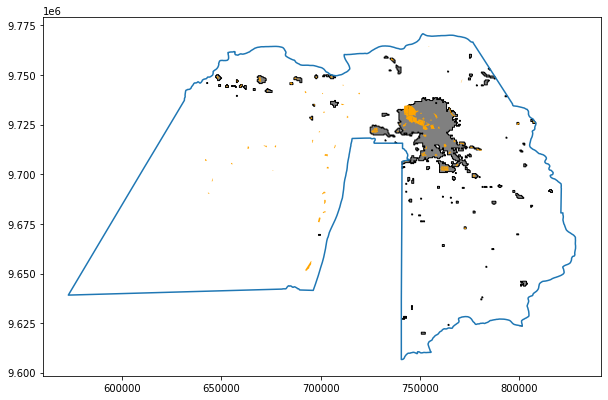

In [112]:
out_path = 'D:/INPE_DISCIPLINAS/Dissertacao/testes/luzNot_CAMETA_2020_Limiar_within_COMPLETO.shp' # LOCAL SHP LIMIARIZADO
arquivo_utm = gpd.read_file('D:/INPE_DISCIPLINAS/Dissertacao/shapes/vias/vias_str_uniao.shp')

################### COMPARAR VETORES - SOBREPOSICAO #################
luz_not = gpd.read_file(out_path)

area_gpd = area_gpd.to_crs(arquivo_utm.crs)
luz_not = luz_not.to_crs(arquivo_utm.crs)

# https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.set_crs.html
reproj = luz_not.to_crs(arquivo_utm.crs)
reproj = reproj[reproj['Value'] == 1] #.dissolve()
reproj = gpd.clip(reproj, area_gpd)


base = reproj.plot(color='grey', edgecolor='black', figsize=(10, 20))
#base.set_title(f'{sc_urb} \nlaranja = setores considerados \ncinza = luz noturna com limiar {limiar} \n%{round(per, 2)} dos setores inseridos')
area_urb_peri.plot(ax=base, marker='o', color='orange', markersize=5, figsize=(15, 30))
area_gpd.boundary.plot(ax=base)

In [118]:
#pip install folium
import folium

In [122]:
reproj_json = reproj.to_json() 
reproj_geojson = folium.features.GeoJson(reproj)
#area_urb_peri.plot(ax=base, marker='o', color='orange', markersize=5, figsize=(15, 30))
#area_gpd.boundary.plot(ax=base)

In [123]:
fmap = folium.Map()

fmap.add_child(reproj_geojson)